## Checkpoint 2 - Data Analysis

In this notebook we will go through the preprocessing of the data and the basic data exploration. Our data set is called "healthcare-dataset-stroke-data.csv" and it contains information about patients and whether they had a stroke or not, and many of the patients' characteristics.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import levene
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
# Import dataset and overview
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')
dataset.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


From this we can make several intersting observations. First we see that we have multiple features that are strings (objects), second we see that we have missing values in the bmi column. We will have to deal with these issues before we can start building our models.

### Gender column from string to binary values

We begin by converting the gender strings to binary values. We will assign 1 to Male and 0 to Female.

In [4]:
# Here we make the gender column binary
dataset['gender'] = dataset['gender'].map({'Male': 1, 'Female': 0})
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,0.0,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,1.0,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,0.0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,0.0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
dataset['gender'].unique()

array([ 1.,  0., nan])

We see that there is a nan value in the gender column. Lets see how many nan values we have in the and how they look.

In [6]:
nan_gender_rows = dataset[dataset['gender'].isna()]
print(nan_gender_rows)

         id  gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156     NaN  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0  


Since it's a single occassion we will just drop the row with the nan value.

In [7]:
dataset.dropna(subset=['gender'], inplace=True)

### Converting 'ever_married' column to binary values

We see that the 'ever_married' column is also a string. We will convert it to binary values. We will assign 1 to Yes and 0 to No.

In [8]:
dataset['ever_married'] = dataset['ever_married'].map({'Yes': 1, 'No': 0})

In [9]:
dataset['ever_married'].unique()

array([1, 0])

### Converting 'work_type' column to intergers

In [10]:
dataset['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

We will assign a number to each work type. We will assign 0 to 'Private', 1 to 'Self-employed', 2 to 'Govt_job', 3 to 'children' and 4 to 'Never_worked'.

In [11]:
dataset['work_type'] = dataset['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})

### Converting 'Residence_type' column to binary values

In [12]:
dataset['Residence_type'].unique()

array(['Urban', 'Rural'], dtype=object)

We will assign 1 to Urban and 0 to Rural.

In [13]:
dataset['Residence_type'] = dataset['Residence_type'].map({'Urban': 1, 'Rural': 0})

### Converting 'smoking_status' column to intergers

In [14]:
dataset['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [15]:
# Here we will check the amount of missing values in the dataset

print(dataset['smoking_status'].value_counts())

# percentage
print(dataset['smoking_status'].value_counts(normalize=True))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64
smoking_status
never smoked       0.370327
Unknown            0.302212
formerly smoked    0.173028
smokes             0.154433
Name: proportion, dtype: float64


We will assign a number to each smoking status. We will assign 0 to 'never smoked', 1 to 'formerly smoked', 2 to 'smokes' and 3 to 'Unknown'.


In [16]:
dataset['smoking_status'] = dataset['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 3})

dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,1,0,1,228.69,36.6,1,1
1,51676,0.0,61.0,0,0,1,1,0,202.21,NaN,0,1
2,31112,1.0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,60182,0.0,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1665,0.0,79.0,1,0,1,1,0,174.12,24.0,0,1


In [17]:
dataset.dtypes

id                     int64
gender               float64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

We have now converted all the string columns to numerical values. Now we check for final NAN values.

In [18]:
dataset.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Lots of missing values in the bmi column. Let's check what percentage of the data is missing.

In [19]:
# Here we check the percentage of missing values in the BMI column
total_rows = len(dataset)
missing_bmi_rows = dataset['bmi'].isna().sum()
missing_bmi_percentage = (missing_bmi_rows / total_rows) * 100
print(f"Percentage of missing BMI data: {missing_bmi_percentage:.2f}%")

Percentage of missing BMI data: 3.93%


Since this is a significant amount of data we will have to deal with this. We will fill the missing values with the mean of the bmi column. But we will add a little normally distributed random noise to the data to make it more realistic using standard deviations. This will make the missing values distribute more evenly. 

In [20]:
bmi_mean = dataset['bmi'].mean()
bmi_std = dataset['bmi'].std()

# The noise will have a mean of 0 and a standard deviation equal to the BMI std
noise = np.random.normal(0, bmi_std, size=dataset['bmi'].isna().sum())

# Creating mask for missing values
mask = dataset['bmi'].isna()

# Imputing missing values
dataset.loc[mask, 'bmi'] = bmi_mean + noise


print(f"Missing BMI data after imputation: {dataset['bmi'].isna().sum()}")

Missing BMI data after imputation: 0


Text(0.5, 1.0, 'Distribution of BMI')

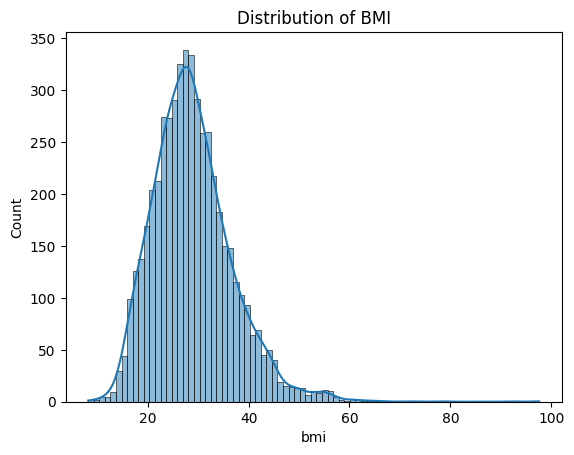

In [21]:
# Plotting the distribution of the BMI
sns.histplot(dataset['bmi'], kde=True)
plt.title('Distribution of BMI')

Now we see that the bmi distribution still fits a normal distribution, even though we added all the missing values around the mean. 

# Outliers

We have three features that are non-binary: BMI, age, avg_gluclose_level. We will check for potential outliers in these columns

In [22]:

fig = make_subplots(rows=1, cols=3, subplot_titles=('BMI', 'Age', 'Avg Glucose Level'))

# Adding a boxplot for BMI 
fig.add_trace(
    go.Box(y=dataset['bmi'], name='BMI', marker_color='skyblue', 
           boxpoints='outliers', 
           marker=dict(outliercolor='red', color='skyblue')), 
    row=1, col=1
)

# Adding a boxplot for Age 
fig.add_trace(
    go.Box(y=dataset['age'], name='Age', marker_color='lightgreen', 
           boxpoints='outliers', 
           marker=dict(outliercolor='orange', color='lightgreen')), 
    row=1, col=2
)

# Adding a boxplot for Avg Glucose Level 
fig.add_trace(
    go.Box(y=dataset['avg_glucose_level'], name='Avg Glucose Level', marker_color='salmon', 
           boxpoints='outliers', 
           marker=dict(outliercolor='purple', color='salmon')), 
    row=1, col=3
)

# Update layout to adjust subplot titles and spacing
fig.update_layout(title_text='Boxplots for BMI, Age, and Avg Glucose Level',
                  showlegend=False,
                  height=500, width=1000)

# Show plot
fig.show()

The Age feature seems good, however BMI and Avg Glucose Level have lots of extreme values so we will have to decide whether or not they are outliers or unusual case of extreme values. First we will check the BMI and put the outliers up with the age values since a baby cannot have a bmi of let's say 100.

In [23]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers in BMI
outliers_bmi = dataset[(dataset['bmi'] < lower_bound) | (dataset['bmi'] > upper_bound)]

# Print out the potential BMI outliers
print("Potential BMI Outliers:")
print(outliers_bmi[['age', 'bmi']])

# Scatter plot to visualize outliers with age
fig = px.scatter(outliers_bmi, x='age', y='bmi', 
                 title='Extreme BMI Values vs Age',
                 labels={'bmi': 'BMI', 'age': 'Age'},
                 color='age')

fig.show()

Potential BMI Outliers:
       age   bmi
21    52.0  48.9
113   45.0  56.6
254   47.0  50.1
258   74.0  54.6
270   57.0  60.9
...    ...   ...
4858  43.0  47.6
4906  53.0  54.1
4952  51.0  56.6
5009  50.0  49.5
5057  49.0  47.6

[114 rows x 2 columns]


We first identified extreme BMI values by detecting outliers using the IQR method. The outliers are those BMI values that fall outside of the range defined by the interquartile range (IQR), which captures the middle 50% of the data. By plotting these outliers against the age values, we can assess whether certain BMI values are unusually high or low relative to age. This is important because, for example, a very young child should not have an excessively high BMI. In this scatter plot, the color represents the age, helping us visualize how BMI outliers vary across different age groups.

In [24]:
Q1 = dataset['bmi'].quantile(0.25)
Q3 = dataset['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Detect outliers based on IQR
outliers_bmi_iqr = dataset[(dataset['bmi'] < lower_bound_iqr) | (dataset['bmi'] > upper_bound_iqr)]

# Now, remove the points that are beyond 2 STDV from the mean of the outliers
mean_bmi_outliers = outliers_bmi_iqr['bmi'].mean()
std_bmi_outliers = outliers_bmi_iqr['bmi'].std()

# 2 STDV bounds for the detected IQR-based outliers
lower_bound_2stdv = mean_bmi_outliers - 2 * std_bmi_outliers
upper_bound_2stdv = mean_bmi_outliers + 2 * std_bmi_outliers

# Filter the IQR-based outliers to remove those beyond 2 STDV
filtered_outliers = outliers_bmi_iqr[(outliers_bmi_iqr['bmi'] >= lower_bound_2stdv) & 
                                     (outliers_bmi_iqr['bmi'] <= upper_bound_2stdv)]

print("Filtered BMI Outliers after removing 2 STDV:")
print(filtered_outliers[['age', 'bmi']])

fig = px.scatter(filtered_outliers, x='age', y='bmi', 
                 title='Filtered Extreme BMI Values (after removing 2 STDV) vs Age',
                 labels={'bmi': 'BMI', 'age': 'Age'},
                 color='age')

fig.show()

Filtered BMI Outliers after removing 2 STDV:
       age   bmi
21    52.0  48.9
113   45.0  56.6
254   47.0  50.1
258   74.0  54.6
270   57.0  60.9
...    ...   ...
4858  43.0  47.6
4906  53.0  54.1
4952  51.0  56.6
5009  50.0  49.5
5057  49.0  47.6

[109 rows x 2 columns]


After detecting the extreme BMI values using the IQR method, we further refined the outliers by removing points that were more than 2 standard deviations away from the mean of these outliers. This step helps in eliminating the most extreme cases, where the BMI values might be considered statistical anomalies. The filtered outliers are plotted against the age values, similar to the previous plot, but now we see only those points that are within a more reasonable range. By comparing the filtered extreme BMI values to the age values, we can gain further insights into whether these BMI values are still unusual given the individual's age.

In [25]:
dataset = dataset[(dataset['bmi'] >= lower_bound_iqr) & (dataset['bmi'] <= upper_bound_iqr) | 
                  ((dataset['bmi'] >= lower_bound_2stdv) & (dataset['bmi'] <= upper_bound_2stdv))]

print(f"Updated dataset size after removing outliers: {len(dataset)}")
dataset.head()

Updated dataset size after removing outliers: 5104


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,67.0,0,1,1,0,1,228.69,36.600000,1,1
1,51676,0.0,61.0,0,0,1,1,0,202.21,25.077037,0,1
2,31112,1.0,80.0,0,1,1,0,0,105.92,32.500000,0,1
3,60182,0.0,49.0,0,0,1,0,1,171.23,34.400000,2,1
4,1665,0.0,79.0,1,0,1,1,0,174.12,24.000000,0,1


Now let's look at the glucose levels and do the same

In [26]:

Q1 = dataset['avg_glucose_level'].quantile(0.25)
Q3 = dataset['avg_glucose_level'].quantile(0.75)

IQR = Q3 - Q1

# define lower and upper bounds for outliers based on avg_glucose_level
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# detect outliers in avg_glucose_level
outliers_glucose = dataset[(dataset['avg_glucose_level'] < lower_bound) | (dataset['avg_glucose_level'] > upper_bound)]

print("Potential Avg Glucose Level Outliers:")
print(outliers_glucose[['age', 'avg_glucose_level']])

# scatter plot to visualize avg_glucose_level outliers with age
fig = px.scatter(outliers_glucose, x='age', y='avg_glucose_level', 
                 title='Extreme Avg Glucose Level Values vs Age',
                 labels={'avg_glucose_level': 'Avg Glucose Level', 'age': 'Age'},
                 color='age')

fig.show()


Potential Avg Glucose Level Outliers:
       age  avg_glucose_level
0     67.0             228.69
1     61.0             202.21
3     49.0             171.23
4     79.0             174.12
5     81.0             186.21
...    ...                ...
5061  41.0             223.78
5062  82.0             211.58
5063  39.0             179.38
5064  70.0             193.88
5076  34.0             174.37

[627 rows x 2 columns]


In [27]:
# Here, we will remove the outliers based on the IQR method and then filter out the points that are beyond 2 STDV from the mean of the outliers

Q1 = dataset['avg_glucose_level'].quantile(0.25)
Q3 = dataset['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1

lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

outliers_glucose_iqr = dataset[(dataset['avg_glucose_level'] < lower_bound_iqr) | (dataset['avg_glucose_level'] > upper_bound_iqr)]

mean_glucose_outliers = outliers_glucose_iqr['avg_glucose_level'].mean()
std_glucose_outliers = outliers_glucose_iqr['avg_glucose_level'].std()

lower_bound_2stdv = mean_glucose_outliers - 2 * std_glucose_outliers
upper_bound_2stdv = mean_glucose_outliers + 2 * std_glucose_outliers

filtered_outliers = outliers_glucose_iqr[(outliers_glucose_iqr['avg_glucose_level'] >= lower_bound_2stdv) & 
                                         (outliers_glucose_iqr['avg_glucose_level'] <= upper_bound_2stdv)]

dataset = dataset[~dataset.index.isin(outliers_glucose_iqr[~outliers_glucose_iqr.index.isin(filtered_outliers.index)].index)]

print(f"Number of outliers remaining after removing 2 STDV: {len(filtered_outliers)}")
outliers_removed = len(outliers_glucose_iqr) - len(filtered_outliers)
print(f"Number of outliers removed based on 2 STDV: {outliers_removed}")

fig = px.scatter(filtered_outliers, x='age', y='avg_glucose_level', 
                 title='Filtered Extreme Avg Glucose Level Values (after removing 2 STDV) vs Age',
                 labels={'avg_glucose_level': 'Avg Glucose Level', 'age': 'Age'},
                 color='age')

fig.show()

Number of outliers remaining after removing 2 STDV: 606
Number of outliers removed based on 2 STDV: 21


After identifying extreme outliers in average glucose levels using the IQR method, we applied a further filter based on 2 standard deviations from the mean of the IQR-detected outliers. This process allowed us to exclude the most extreme values while retaining those that were reasonably close to the average. The final dataset was updated to reflect the removal of these outliers, ensuring more accurate and reliable analysis moving forward.

In [28]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('BMI', 'Age', 'Avg Glucose Level'))

# Adding a boxplot for BMI 
fig.add_trace(
    go.Box(y=dataset['bmi'], name='BMI', marker_color='skyblue', 
           boxpoints='outliers', 
           marker=dict(outliercolor='red', color='skyblue')), 
    row=1, col=1
)

# Adding a boxplot for Age 
fig.add_trace(
    go.Box(y=dataset['age'], name='Age', marker_color='lightgreen', 
           boxpoints='outliers', 
           marker=dict(outliercolor='orange', color='lightgreen')), 
    row=1, col=2
)

# Adding a boxplot for Avg Glucose Level 
fig.add_trace(
    go.Box(y=dataset['avg_glucose_level'], name='Avg Glucose Level', marker_color='salmon', 
           boxpoints='outliers', 
           marker=dict(outliercolor='purple', color='salmon')), 
    row=1, col=3
)

# Update layout to adjust subplot titles and spacing
fig.update_layout(title_text='Boxplots for BMI, Age, and Avg Glucose Level',
                  showlegend=False,
                  height=500, width=1000)

# Show plot
fig.show()

### Variances of features

Let's have a look at the variances of the features, age, avg_glucose_level and bmi

In [29]:
print(dataset[['age', 'avg_glucose_level', 'bmi']].var())

age                   510.939978
avg_glucose_level    1972.854435
bmi                    60.152275
dtype: float64


Unfortunately we see a big difference in variances, but lets confirm this first with a hypothesis test. Here we should choose a Levene test since we are comparing the variances of multiple groups.


We are conducting a hypothesis test to determine whether the variances of the three features (`age`, `avg_glucose_level`, and `bmi`) are significantly different.

#### **Null Hypothesis (H₀):**
The variances of the features are equal.
$H_0: \sigma_{\text{age}}^2 = \sigma_{\text{avg\_glucose\_level}}^2 = \sigma_{\text{bmi}}^2$


#### **Alternative Hypothesis (H₁):**
At least one feature has a variance that is different from the others.
$H_1: \text{At least one variance is different}$

#### **Test:**
We will use **Levene's Test** to test for equality of variances.

- If the **p-value < 0.05**, we will reject the null hypothesis, indicating that the variances are significantly different.
- If the **p-value ≥ 0.05**, we fail to reject the null hypothesis, suggesting there is no significant difference in variances.


In [30]:
stat, p_value = levene(dataset['age'], dataset['avg_glucose_level'], dataset['bmi'], center='mean')
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 2436.7322331433384
p-value: 0.0


We see that the p-value is less than 0.05, so we reject the null hypothesis. This means that the variances are significantly different. We will have to standardize the data before we can build our models.

This is how the data looks without having standardized it. We see that the features are on different scales.

In [31]:
# Select specific numerical columns
selected_cols = ['age', 'avg_glucose_level', 'bmi']

# Melt the dataset for easier plotting 
df_melted = dataset.reset_index()[['index'] + selected_cols].melt(id_vars=['index'], 
                                                                  value_vars=selected_cols, 
                                                                  var_name='Feature', 
                                                                  value_name='Value')

# Plot 
fig = px.line(df_melted, x='index', y='Value', color='Feature',
              title='Line Plot of Selected Numerical Features',
              labels={'index': 'Observations', 'Value': 'Values'})

# Show the plot
fig.show()

Now we can try and standardize the data. We will use the StandardScaler from sklearn to do this. This will make the features have a mean of 0 and a standard deviation of 1.

In [32]:
# Split the dataset into features and target
selected_cols = ['age', 'avg_glucose_level', 'bmi']

# Standardize the selected columns
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(dataset[selected_cols])

# Replace the original columns with the scaled data
dataset[selected_cols] = scaled_data

# Melt the dataset for easier plotting
df_melted = dataset.reset_index()[['index'] + selected_cols].melt(id_vars=['index'], 
                                                                  value_vars=selected_cols, 
                                                                  var_name='Feature', 
                                                                  value_name='Scaled Value')

# Plot using Plotly Express
fig = px.line(df_melted, x='index', y='Scaled Value', color='Feature',
              title='Line Plot of Scaled Selected Numerical Features',
              labels={'index': 'Observations', 'Scaled Value': 'Scaled Values'})

# Show the plot
fig.show()

The result of the standardization looks like this and we see that the features are now on the same scale. 

Although we do notice is that there are some significant outliers in the bmi column. Lets see if these are really outliers or if they are just extreme values.

# Smoker Unknown

The presence of "Unknown" in the smoking status variable poses a challenge for accurate data analysis. These "Unknown" values act similarly to missing data (like NaN) and can distort the relationships between variables. In the original dataset, the "Unknown" category creates uncertainty, as it doesn't provide any useful information about the smoking habits of these individuals. This makes it difficult to assess the true correlations involving smoking status.

Imputation offers one solution by predicting these missing values based on patterns in the data. However, this can introduce bias if the predicted values aren't fully accurate. Another approach is to remove the "Unknown" values entirely, but this reduces the dataset's size and may impact the overall quality of analysis.

Addressing this issue is crucial for building reliable models and ensuring the correlations between variables remain meaningful.

We are gonna try every approach and see which one gives us the best results.

Below we will try to predict the missing values using a Random Forest Classifier. We will use the other features to predict the missing values in the smoking_status column. Although we are going to drop the 'id' and 'smoking_status' columns since we are going to predict the missing values in the 'smoking_status' column, and 'id' is not a feature that can help us predict the missing values.

In [33]:
# Here we are training a Random Forest Classifier to predict the 'Unknown' smoking statuses

# Filter out the 'Unknown' smoking statuses (where smoking_status == 3)
filtered_data = dataset[dataset['smoking_status'] != 3]

# Drop the 'id' column and the 'smoking_status' column (target variable)
X = filtered_data.drop(['id', 'smoking_status'], axis=1)
y = filtered_data['smoking_status']

# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
classification_reports = []

# Perform KFold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Training fold {fold + 1}...")

    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Accuracy for fold {fold + 1}: {accuracy:.2f}")

    # Store the classification report for this fold
    report = classification_report(y_test, y_pred, target_names=['never smoked', 'formerly smoked', 'smokes'], output_dict=True)
    classification_reports.append(report)

# Calculate and display the average accuracy across all folds
avg_accuracy = np.mean(accuracy_scores)
print(f"\nAverage accuracy across all folds: {avg_accuracy:.2f}")


# Now that the model is validated, we will retrain on the entire dataset to predict the 'Unknown' smoking statuses

# Train on the entire filtered dataset
rf_classifier.fit(X, y)

# Predict smoking status for the 'Unknown' cases
unknown_data = dataset[dataset['smoking_status'] == 3]
X_unknown = unknown_data.drop(['id', 'smoking_status'], axis=1)
predicted_smoking_status = rf_classifier.predict(X_unknown)

# Create a new dataset with these predictions
dataset_rf_imputed = dataset.copy()
dataset_rf_imputed.loc[dataset_rf_imputed['smoking_status'] == 3, 'smoking_status'] = predicted_smoking_status


print("Smoking statuses imputed for unknown cases.")

Training fold 1...
Accuracy for fold 1: 0.52
Training fold 2...
Accuracy for fold 2: 0.48
Training fold 3...
Accuracy for fold 3: 0.47
Training fold 4...
Accuracy for fold 4: 0.46
Training fold 5...
Accuracy for fold 5: 0.51
Training fold 6...
Accuracy for fold 6: 0.52
Training fold 7...
Accuracy for fold 7: 0.47
Training fold 8...
Accuracy for fold 8: 0.52
Training fold 9...
Accuracy for fold 9: 0.58
Training fold 10...
Accuracy for fold 10: 0.49

Average accuracy across all folds: 0.50
Smoking statuses imputed for unknown cases.


Now we can create the dataset entirely without the 'Unknown' values in the 'smoking_status' column. 

In [34]:
dataset_removed = dataset[dataset['smoking_status'] != 3]

We compare three versions of our dataset to determine which is best for analysis. The first is the original dataset, which includes all the raw data but has some smoking statuses labeled as "Unknown." While these aren’t technically missing values, "Unknown" acts similarly to missing data (like NaN) in this case. The second is the imputed dataset, where "Unknown" smoking statuses are predicted using a Random Forest model, allowing us to retain more data while preserving relationships between variables. The third version removes all rows with "Unknown" smoking status, reducing the data size but eliminating uncertainty.

By comparing the correlation matrices, we assess how each approach affects the relationships between variables and choose the most reliable dataset for further analysis.

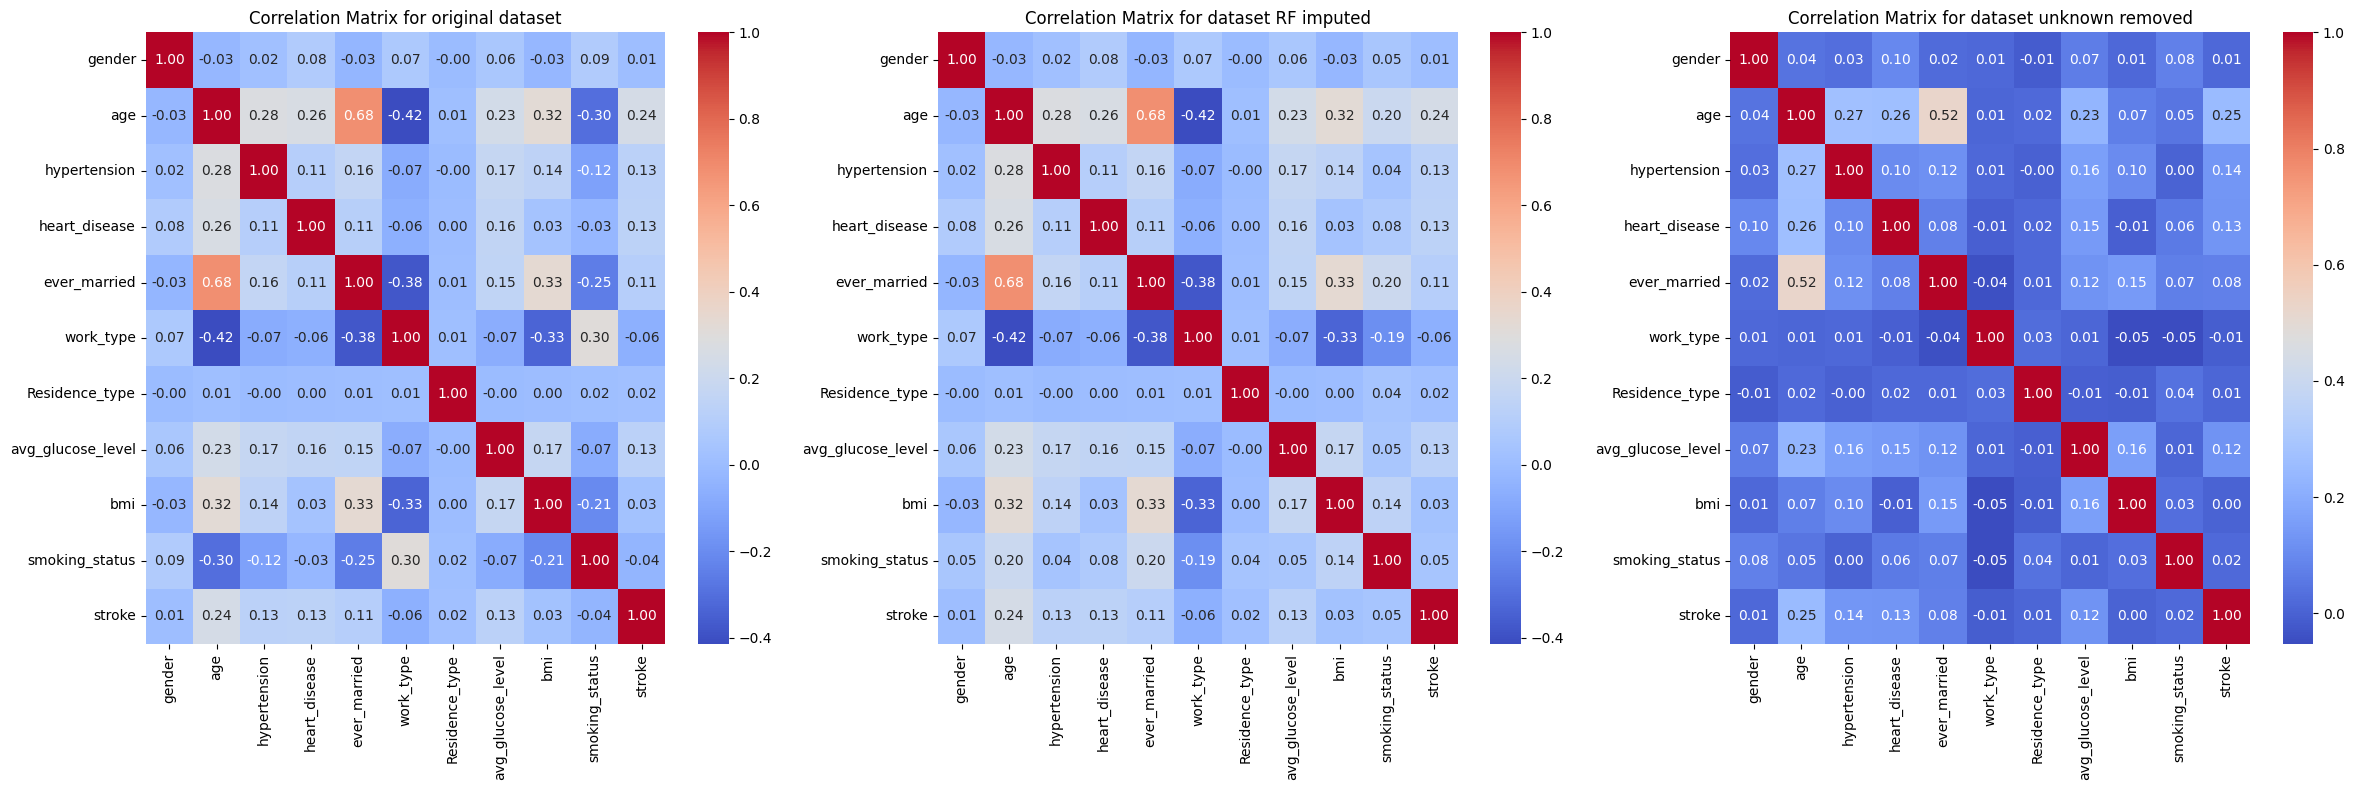

In [35]:
# Drop the 'id' column from each dataset
dataset_no_id = dataset.drop(columns=['id'])
dataset_rf_imputed_no_id = dataset_rf_imputed.drop(columns=['id'])
dataset_removed_no_id = dataset_removed.drop(columns=['id'])

# Compute the correlation matrices
corr_dataset = dataset_no_id.corr()
corr_rf_imputed = dataset_rf_imputed_no_id.corr()
corr_removed = dataset_removed_no_id.corr()

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.heatmap(corr_dataset, annot=True, fmt='.2f', ax=axes[0], cmap='coolwarm')
axes[0].set_title('Correlation Matrix for original dataset')

sns.heatmap(corr_rf_imputed, annot=True, fmt='.2f', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Correlation Matrix for dataset RF imputed')

sns.heatmap(corr_removed, annot=True, fmt='.2f', ax=axes[2], cmap='coolwarm')
axes[2].set_title('Correlation Matrix for dataset unknown removed')

plt.tight_layout()
plt.show()

We decide to move forward with the random forest imputed dataset because it provides a balanced and comprehensive approach to handling missing data while preserving the integrity of the dataset.

First, by using random forest imputation, we address the missing or "unknown" smoking status values in a way that relies on the relationships between other variables in the data. This is much more effective than simply categorizing these values as "Unknown" or removing them entirely. It allows us to retain more data, which increases the sample size and, in turn, the statistical power of our analysis.

Another important reason for choosing this approach is that it preserves the natural structure and relationships within the dataset. Imputation through random forests uses patterns from existing data to predict missing values, which means the dataset remains internally consistent and closer to reality. This increases the accuracy of any insights or models that rely on this data.

Additionally, the imputed dataset retains around 1500 more observations compared to the dataset with outliers removed, ensuring we don’t lose valuable information. The more data we can use, the better our chances of building robust models and drawing meaningful conclusions.

When we compared the correlation matrices, we noticed that the imputed dataset maintained similar relationships to those found in the original dataset, showing that the imputation process didn’t disrupt key correlations. In contrast, removing outliers led to shifts in some relationships, likely due to the reduction in sample size.

In short, choosing the random forest imputed dataset means we keep a more complete dataset, preserve essential correlations, and ensure that missing values are handled thoughtfully. This approach provides a solid foundation for our analysis, leading to more reliable and accurate results.

In [36]:
dataset_rf_imputed.head(20)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1.0,1.054692,0,1,1,0,1,2.771797,0.998032,1,1
1,51676,0.0,0.789226,0,0,1,1,0,2.175568,-0.487838,0,1
2,31112,1.0,1.629868,0,1,1,0,0,0.007482,0.469343,0,1
3,60182,0.0,0.258294,0,0,1,0,1,1.478016,0.714345,2,1
4,1665,0.0,1.585624,1,0,1,1,0,1.543088,-0.626721,0,1
5,56669,1.0,1.674113,0,0,1,0,1,1.815309,0.018022,1,1
6,53882,1.0,1.364402,1,1,1,0,0,-0.799273,-0.188295,0,1
7,10434,0.0,1.143181,0,0,0,0,1,-0.252129,-0.781459,0,1
8,27419,0.0,0.700737,0,0,1,0,0,-0.662825,0.921336,1,1
9,60491,0.0,1.541380,0,0,1,0,1,-1.058660,-0.600931,0,1


This is what the data looks like after we have imputed the missing values in the 'smoking_status' column. And the data is now ready for building models.

## Checkpoint 3 - Final deliverable of DS Project

In [38]:
# seeding for reproducibility
np.random.seed(42)